## Train Classifier: Random Forrest

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, load_from_disk
from sklearn.metrics import accuracy_score
import random
import numpy as np
import torch
import os

/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
topic = "energie" #"energie" #"kinder" "cannabis"

## Load Dataset

In [3]:
dataset = load_from_disk(f"../../data/tmp/processed_dataset_{topic}_buffed_chunkified_random_384")

In [4]:
# Sample 100 random indices from the training dataset
#random_indices = random.sample(range(len(dataset['train'])), 100)

# Select 100 examples from the training dataset
#dataset['train'] = dataset['train'].select(random_indices)

In [5]:
# Explore the dataset
print(dataset)
print(dataset['train'][0]) 

DatasetDict({
    train: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count', 'chunk_id'],
        num_rows: 3398
    })
    test: Dataset({
        features: ['_id', 'batch_id', 'domain', 'view_url', 'lang', 'text', 'text_length', 'word_count', 'topic', 'category', 'good_for_training', 'good_for_augmentation', 'annotation_type', 'is_topic', 'label', 'token_count', 'chunk_id'],
        num_rows: 478
    })
})
{'_id': '64a0946d749484eec855d4bb', 'batch_id': 16, 'domain': 't-online.de', 'view_url': 'email.t-online.de/em#f=INBOX&m=15411876806784410&method=showReadmail', 'lang': 'de', 'text': 'Wetter DAX Telefonverzeichnisse Lotto Telekom Services Telekom Hilfe & Service Frag Magenta Kundencenter Freemail MagentaCloud Tarife & Produkte PUR-Abo Login Suchen E-Mail Login Politik Deutschland Ausland Corona-Krise

**Define Stopwords**

In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

german_stop_words = stopwords.words('german')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jschelb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Train Model**

In [7]:
train_data = dataset['train']
test_data = dataset['test'] 

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=german_stop_words, max_features=10000)  # Adjust the number of features as needed

# Vectorize the training data
X_train = vectorizer.fit_transform(train_data['text'])

# Vectorize the test data using the same vectorizer
X_test = vectorizer.transform(test_data['text'])


In [9]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust parameters as needed

# Train the model on the training data
clf.fit(X_train, y_train)

# Evaluate the model on the test (validation) data
print("Model accuracy on test data:", clf.score(X_test, y_test))


Model accuracy on test data: 0.9309623430962343


## Investiaget Feature Importance

In [11]:
importances = clf.feature_importances_

In [12]:
# Map feature indices back to the original token (word)
feature_names = vectorizer.get_feature_names_out()
features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)


In [13]:
# Select the top 10 features
top_n = 25
top_features = features[:top_n]

# Print the top N features
for token, importance in top_features:
    print(f"Token: {token}, Importance: {importance}")


Token: eeg, Importance: 0.025492751968152517
Token: energien, Importance: 0.022741474112529265
Token: strom, Importance: 0.019349865641094324
Token: anlagen, Importance: 0.017011865825311123
Token: erneuerbare, Importance: 0.015834992161906324
Token: erneuerbaren, Importance: 0.01545994383386998
Token: energie, Importance: 0.013918505468546623
Token: 2024, Importance: 0.01322614309858636
Token: pv, Importance: 0.013062741930753295
Token: erneuerbarer, Importance: 0.011068278869655994
Token: förderung, Importance: 0.01096756797534573
Token: gesetz, Importance: 0.009937795886273765
Token: bundesregierung, Importance: 0.009790725053472117
Token: photovoltaik, Importance: 0.009143840513182878
Token: anlage, Importance: 0.007972524105499224
Token: windenergie, Importance: 0.007959956217669754
Token: wärme, Importance: 0.007427805266552959
Token: energiewende, Importance: 0.007176721735625896
Token: ausschreibungen, Importance: 0.006784852087157699
Token: loading, Importance: 0.0066042022674

In [14]:
predictions = clf.predict(X_test)

In [15]:
predictions

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,

## Evaluate

In [16]:
labels = y_test
preds = predictions

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming labels and preds are lists or arrays containing the true labels and predicted labels respectively
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Accuracy: 93.10%
Precision: 0.95
Recall: 0.93
F1 Score: 0.94


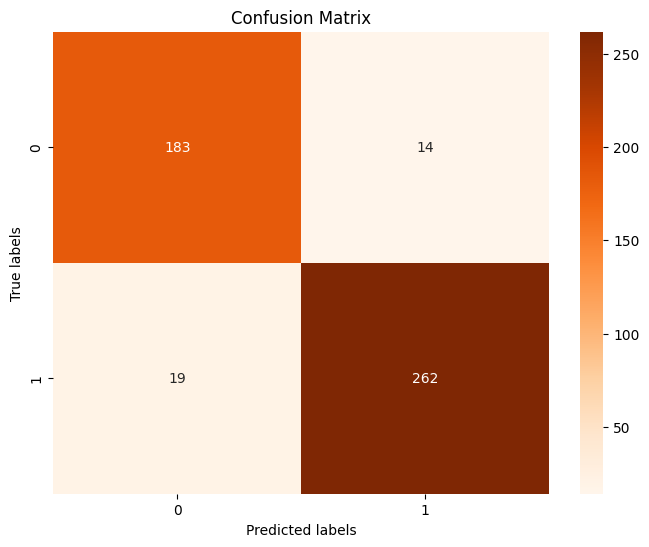

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming labels and preds are lists or arrays containing the true labels and predicted labels respectively
cm = confusion_matrix(labels, preds)

# Create a seaborn heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=True)

# Add labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")

# Show plot
plt.show()
